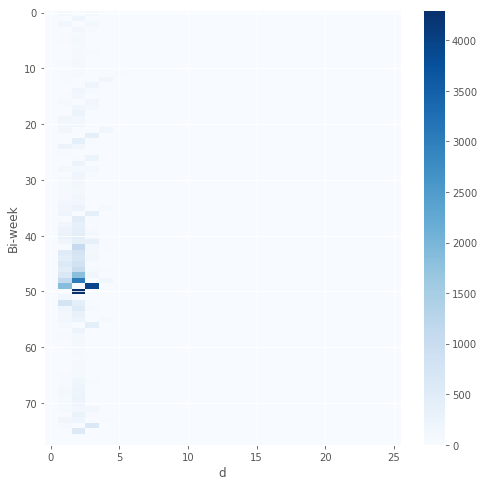

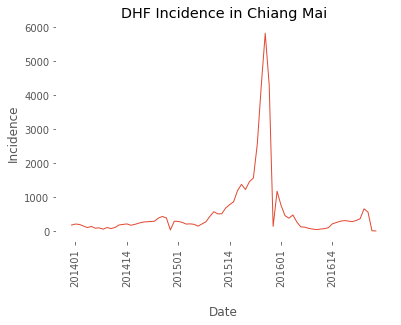

In [69]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout
            
            
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams['lines.linewidth']=1
plt.rcParams['axes.facecolor']='w'

n_t_d = []
with open("province-biweek_with_delays.csv") as f:
    i = 0
    for line in f.readlines():
        if i > 0:
            n_t_d.append(line.replace("\n","").split(','))
        i+=1

n_t_d_1 = []

for elm in n_t_d:
    if elm[2] == "10":
        n_t_d_1.append(elm)


index_to_dates = {}
dates_to_index = {}
count = 0
for i in ["2014","2015","2016"]:
    for j in range(1,27):
        index_to_dates[count] = str(i)+str(j)
        dates_to_index[str(i)+str(j)] = count
        count +=1
        
reporting_matrix = np.zeros((26*3,26*3))

for elm in n_t_d_1:
    try:
        sick_date = elm[0]+elm[1]
        report_date = elm[-2] + elm[-1]
        cases = elm[3]
        reporting_matrix_row = dates_to_index[sick_date] 
        reporting_matrix_col =  dates_to_index[report_date] 
        reporting_matrix[reporting_matrix_row,reporting_matrix_col] = int(cases)
    except:
        pass
np.set_printoptions(suppress=True)    #np.set_printoptions(threshold=np.nan)


D=26
n_t_d = np.zeros((len(reporting_matrix),D))

for i in range(len(reporting_matrix)):
    for j in range(i,i+D):
        try:
            n_t_d[i,j-i] = reporting_matrix[i][j]
        except:
            pass
n_t_d = n_t_d 

from matplotlib.pyplot import cm


def sim_data(x,y,z):
    return n_t_d[:y]



pos=[]
biweek_x_label = []
for year in ["2014","2015","2016"]:
    for j in np.arange(1,27,13):
        if j <= 9:
               biweek_x_label.append(year + "0"+ str(j))

        else:
               biweek_x_label.append(year +  str(j))
        if year == "2014":
               pos.append(j)
        elif year == "2015":
               pos.append(j+26)
        elif year == "2016":
               pos.append(j+26*2)

from matplotlib.pyplot import cm
plt.figure(figsize=(8,8))
plt.ylabel("Bi-week")
plt.xlabel("d")
plt.imshow(n_t_d,aspect='auto',cmap=cm.Blues)
plt.legend()
plt.colorbar()
plt.show()

plt.plot(n_t_d.sum(axis=1))
plt.xticks(pos, biweek_x_label, rotation='vertical')
plt.xlabel("\nDate")
plt.title("DHF Incidence in Chiang Mai")
plt.ylabel("Incidence")
plt.show()

In [110]:
def bayes_estimate_prob(po_data,m2,alphas,LO,N_SIM):
    ret_arr = []
    phat = alphas/sum(alphas)
    for s_ in range(N_SIM):
        count = LO
        for row in np.arange(LO,0,-1):
                tmp_n_t_inf = np.max((m2[s_][(D-row)],po_data[D-row]))
                sigma_2_0 = 1
                sigma_2 =   tmp_n_t_inf*sum(phat[:row])*(1-sum(phat[:row]))
                post_mean = (1.*sigma_2_0/(sigma_2_0+sigma_2))*po_data[D-row] \
                          +(1.*sigma_2/(sigma_2_0+sigma_2))*tmp_n_t_inf
                post_var = 1./(1./sigma_2_0 + 1./sigma_2) + .000001
               # print (post_mean,post_var)
                

                ret_arr.append(np.random.normal(post_mean, np.sqrt(post_var),size=100))
                #ret_arr.append(po_data[D-row]/sum(phat[:row]))
                count -=1
    
    return ret_arr

In [117]:
from scipy.special import expit
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
variance_level_results = []
import sys
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
from sklearn.metrics import mean_squared_error
from pyramid.arima import ARIMA

import os

rmse_vec_cv = []
#with suppress_stdout():
rmse_vec = []
sim_data_var = []
N_SIM = 1000
sim_results_pi = []
sim_results_mse = []
for sim_num in np.arange(30,60):
            sim_n_t_d = sim_data(D,sim_num,False)
            train = sim_n_t_d
            


            train = np.array(train)
            train_n_t_d = train.reshape((-1,D))
            ts = train_n_t_d.sum(axis=1)
            data_to_be_scaled_down  = train_n_t_d[len(ts)-D:]




            delayed_data = []
            count = D
            for i in range(len(data_to_be_scaled_down)):
                tmp = data_to_be_scaled_down[i][:count].tolist()
                while len(tmp) <D:
                    tmp.append(0)
                delayed_data.append(tmp)
                count -=1 


            training_data = np.append(train_n_t_d[:len(ts)-D],delayed_data,axis=0)

            k = np.array(train_n_t_d).shape[1 ]
            alphas = np.ones(k)

            for i in range(len(ts)-D):
                alphas += train_n_t_d[i]

            
           
            #######
            # MODEL 1: Delay
            ########
            delay_model_samples = []
            for s_ in range(N_SIM):
                model_1_delay = []
                count = D
                p_vec_noise = np.random.dirichlet(alphas)
                for i in range(len(delayed_data)):
                    delay_forecast = np.sum(delayed_data[i])/np.sum(p_vec_noise[:count])
                    model_1_delay.append(np.round(delay_forecast,2))
                    count -= 1
                delay_model_samples.append(model_1_delay)
            
            delay_model_samples = np.array(delay_model_samples)
            

            #######
            # MODEL 2 : Forecast
            ########
            
            LO=5
            process_training_data = np.append(ts[:len(ts)-D],model_1_delay[:D-LO],axis=0)
            from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
            #myDLM = dlm(process_training_data)
            #myDLM = myDLM + seasonality(26, name='7day', w=1.0)
            #myDLM = myDLM + autoReg(degree=2, data=process_training_data, name='ar2', w=1.0)
            #myDLM.fit()
            #(process_model_forecast, predictVar) = myDLM.predictN(N=LO, date=myDLM.n-1)
            
            from pyramid.arima import auto_arima

            stepwise_model = ARIMA(order=(1, 1, 0), seasonal_order=(1, 0, 0, 4)).fit(y=process_training_data)
            
            
            process_model_forecast =  stepwise_model.predict(n_periods=LO)
           
            predictVar = 10*np.ones(len(process_model_forecast))
            #######
            # MODEL 2
            ########
            forecast_model_samples = []
            for s_ in range(N_SIM):
                model_2_delay = []
                count = D
                for i in np.arange(LO,0,-1):
                    tmp = np.random.normal(process_model_forecast[LO-i],np.sqrt(predictVar[LO-i]))
                    model_2_delay.append(np.round(tmp,2))
                    count -= 1

                forecast_model_samples.append(np.append(model_1_delay[:D-LO],model_2_delay))
            
            forecast_model_samples = np.array(forecast_model_samples)
            
                
            model_average = bayes_estimate_prob(np.sum(delayed_data,axis=1),forecast_model_samples,alphas,LO,N_SIM)
            
            model_average = np.transpose(np.array(model_average).reshape((-1,LO)))
            delay_model_samples = np.transpose(np.array(delay_model_samples))
            forecast_model_samples = np.transpose(np.array(forecast_model_samples))
            
            delay_sim_res = delay_model_samples
            fcast_sim_res = forecast_model_samples
            avg_sim_res = model_average
            LO_av = avg_sim_res
            LO_delay = delay_sim_res[D-LO:]
            LO_fcast = fcast_sim_res[D-LO:]
            LO_truth = ts[len(ts)-LO:]
            
            sim_results_mse.append([mean_absolute_error(np.mean(LO_delay,axis=1),LO_truth),\
                                   mean_absolute_error(np.mean(LO_fcast,axis=1),LO_truth),\
                                   mean_absolute_error(np.mean(LO_av,axis=1),LO_truth)])
            print (sim_results_mse[-1])
            av_cp = 0
            fcast_cp = 0
            delay_cp = 0
            for i in range(LO):
                LO_av_ci = np.round(np.percentile(LO_av[i],[2.5,97.5]))
                LO_fcast_ci = np.round(np.percentile(LO_fcast[i],[2.5,97.5]))
                LO_delay_ci = np.round(np.percentile(LO_delay[i],[2.5,97.5]))
                print (LO_delay_ci,LO_fcast_ci,LO_av_ci, LO_truth[i])
                if LO_av_ci[0] <= LO_truth[i] <= LO_av_ci[1]:
                    av_cp +=1

                if LO_fcast_ci[0] <= LO_truth[i] <= LO_fcast_ci[1]:
                    fcast_cp +=1

                if LO_delay_ci[0] <= LO_truth[i] <= LO_delay_ci[1]:
                    delay_cp +=1


            av_cp = 1.*av_cp/LO
            fcast_cp = 1.*fcast_cp/LO
            delay_cp = 1.*delay_cp/LO

            print (delay_cp,fcast_cp,av_cp)
            sim_results_pi.append([delay_cp,fcast_cp,av_cp])

[61.286332000000186, 258.7460520000003, 233.754168994671]
(array([30., 31.]), array([413., 425.]), array([391., 488.]), 28.0)
(array([292., 305.]), array([456., 468.]), array([391., 488.]), 287.0)
(array([340., 374.]), array([480., 492.]), array([391., 488.]), 279.0)
(array([238., 301.]), array([473., 486.]), array([391., 488.]), 252.0)
(array([0., 0.]), array([487., 499.]), array([391., 488.]), 201.0)
(0.2, 0.0, 0.0)


/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


[85.24477599999992, 566.500068, 106.99975689695748]
(array([290., 301.]), array([-161., -148.]), array([ -0., 276.]), 287.0)
(array([263., 273.]), array([-262., -249.]), array([ -0., 276.]), 279.0)
(array([228., 250.]), array([-330., -318.]), array([ -0., 276.]), 252.0)
(array([14., 18.]), array([-416., -403.]), array([ -0., 276.]), 201.0)
(array([0., 0.]), array([-469., -456.]), array([ -0., 276.]), 208.0)
(0.0, 0.0, 0.6)
[56.08790399999996, 37.68597399999999, 35.4606801344776]
(array([270., 279.]), array([213., 225.]), array([ 88., 259.]), 279.0)
(array([251., 260.]), array([231., 243.]), array([ 88., 259.]), 252.0)
(array([233., 252.]), array([111., 123.]), array([ 88., 259.]), 201.0)
(array([153., 191.]), array([191., 204.]), array([ 88., 259.]), 208.0)
(array([0., 0.]), array([169., 181.]), array([ 88., 259.]), 194.0)
(0.4, 0.0, 0.8)
[54.57588999999994, 56.666486000000056, 33.72563822980874]
(array([257., 265.]), array([278., 290.]), array([138., 285.]), 252.0)
(array([205., 212.]

[1786.4252320000003, 1757.281886, 1626.6870554353304]
(array([1475., 1488.]), array([1264., 1277.]), array([ 940., 2422.]), 1449.0)
(array([1691., 1725.]), array([1354., 1366.]), array([ 940., 2422.]), 1558.0)
(array([3674., 3836.]), array([1412., 1424.]), array([ 940., 2422.]), 2569.0)
(array([5677., 6402.]), array([1402., 1414.]), array([ 940., 2422.]), 4281.0)
(array([0., 0.]), array([1432., 1444.]), array([ 940., 2422.]), 5824.0)
(0.0, 0.0, 0.4)
[1834.178770000001, 2056.8940679999996, 1730.4860549301804]
(array([1584., 1598.]), array([1552., 1564.]), array([1189., 4117.]), 1558.0)
(array([2797., 2849.]), array([1624., 1636.]), array([1189., 4117.]), 2569.0)
(array([6011., 6247.]), array([1610., 1622.]), array([1189., 4117.]), 4281.0)
(array([8116., 9042.]), array([1695., 1707.]), array([1189., 4117.]), 5824.0)
(array([0., 0.]), array([1743., 1755.]), array([1189., 4117.]), 4307.0)
(0.0, 0.2, 0.4)
[1562.2142039999992, 2380.884304000001, 1984.1226106968174]
(array([2610., 2633.]), ar

ValueError: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.

In [118]:
print np.mean(sim_results_pi,axis=0)
sim_results_mse = np.array(sim_results_mse)
print (sim_results_mse)

print np.round(np.mean(sim_results_mse,axis=0))

argmins = []
for i in range(len(sim_results_mse)):
    argmins.append(np.argmin(sim_results_mse[i]))
    
count = 0 
denom = 0
for arg in argmins:
    if arg ==2:
        count +=1
        denom+=1
    elif arg ==0:
        denom+=1
        
print (1.*count/denom)

[0.04166667 0.01666667 0.49166667]
[[  61.286332    258.746052    233.75416899]
 [  85.244776    566.500068    106.9997569 ]
 [  56.087904     37.685974     35.46068013]
 [  54.57589      56.666486     33.72563823]
 [  62.571694     50.942726     22.24610886]
 [  67.944364     64.209266     48.9666491 ]
 [ 165.476468     78.249306     74.50032905]
 [ 164.51288     153.10851     156.37082327]
 [ 159.794938    254.52152     184.7394367 ]
 [ 270.961892    265.590334    236.74569731]
 [ 255.953982    265.735152    159.7767958 ]
 [ 370.621988    161.112916    145.67870189]
 [ 412.213702    100.218208    143.77340376]
 [ 346.904052    227.379572    252.75589196]
 [ 522.546388    398.731532    386.35563609]
 [ 762.533214    343.796628    302.33116882]
 [ 618.551238    382.13701     304.26009499]
 [ 553.701886    397.884914    299.77476368]
 [ 765.818102    305.083122    361.69589931]
 [1156.936562    754.782384    851.65434623]
 [1786.425232   1757.281886   1626.68705544]
 [1834.17877    2056

In [17]:
from scipy.special import expit
import matplotlib.pyplot as pltq

variance_level_results = []
import sys
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
from sklearn.metrics import mean_squared_error

cv_mse = []
season_data = []
sim_results_mse = []
sim_results_pi = []
for i in range(3):
    season_data.append(reporting_matrix[i:(i+26)])
    
season_data = np.array(season_data).reshape((3,-1,26))

print (season_data.shape)

for season_for_leave_out in np.arange(3):
        sim_n_t_d = season_data#[:cutoff]

        train = [sim_n_t_d[x] for x in range(3) if x not in [season_for_leave_out]]
        test = sim_n_t_d[season_for_leave_out]
        
        train = np.array(train)
        train_n_t_d = train.reshape((-1,D))
        ts = train_n_t_d.sum(axis=1)

        data_to_be_scaled_down  = test[len(test)-D:]
       
        delayed_data = []
        count = D
        for i in range(len(data_to_be_scaled_down)):
            tmp = data_to_be_scaled_down[i][:count].tolist()
            while len(tmp) <D:
                tmp.append(0)
            delayed_data.append(tmp)
            count -=1 


        training_data = np.append(train_n_t_d[:len(ts)-D],delayed_data,axis=0)

        k = np.array(train_n_t_d).shape[1 ]
        alphas = np.ones(k)

        for i in range(len(ts)-D):
            alphas += train_n_t_d[i]



        #######
        # MODEL 1: Delay
        ########
        delay_model_samples = []
        for s_ in range(N_SIM):
            model_1_delay = []
            count = D
            p_vec_noise = np.random.dirichlet(alphas)
            for i in range(len(delayed_data)):
                delay_forecast = np.sum(delayed_data[i])/np.sum(p_vec_noise[:count])
                model_1_delay.append(np.round(delay_forecast,2))
                count -= 1
            delay_model_samples.append(model_1_delay)

        delay_model_samples = np.array(delay_model_samples)


        #######
        # MODEL 2 : Forecast
        ########

        LO=5
        process_training_data = np.append(ts[:len(ts)-D],model_1_delay[:D-LO],axis=0)
        from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
        myDLM = dlm(process_training_data)
       # myDLM = myDLM + seasonality(26, name='7day', w=1.0)
        myDLM = myDLM + autoReg(degree=2, data=process_training_data, name='ar2', w=1.0)
        myDLM.fit()
        (process_model_forecast, predictVar) = myDLM.predictN(N=LO, date=myDLM.n-1)

        #######
        # MODEL 2
        ########
        forecast_model_samples = []
        for s_ in range(N_SIM):
            model_2_delay = []
            count = D
            for i in np.arange(LO,0,-1):
                tmp = np.random.normal(process_model_forecast[LO-i],np.sqrt(predictVar[LO-i]))
                model_2_delay.append(np.round(tmp,2))
                count -= 1

            forecast_model_samples.append(np.append(model_1_delay[:D-LO],model_2_delay))

        forecast_model_samples = np.array(forecast_model_samples)


        model_average = bayes_estimate_prob(np.sum(delayed_data,axis=1),forecast_model_samples,alphas,LO,N_SIM)

        model_average = np.transpose(np.array(model_average).reshape((-1,LO)))
        delay_model_samples = np.transpose(np.array(delay_model_samples))
        forecast_model_samples = np.transpose(np.array(forecast_model_samples))

        delay_sim_res = delay_model_samples
        fcast_sim_res = forecast_model_samples
        avg_sim_res = model_average
        LO_av = avg_sim_res
        LO_delay = delay_sim_res[D-LO:]
        LO_fcast = fcast_sim_res[D-LO:]
        LO_truth = ts[len(ts)-LO:]

        sim_results_mse.append([mean_squared_error(np.mean(LO_delay,axis=1),LO_truth),\
                               mean_squared_error(np.mean(LO_fcast,axis=1),LO_truth),\
                               mean_squared_error(np.mean(LO_av,axis=1),LO_truth)])
        print (sim_results_mse[-1])
        av_cp = 0
        fcast_cp = 0
        delay_cp = 0
        for i in range(LO):
            LO_av_ci = np.round(np.percentile(LO_av[i],[2.5,97.5]))
            LO_fcast_ci = np.round(np.percentile(LO_fcast[i],[2.5,97.5]))
            LO_delay_ci = np.round(np.percentile(LO_delay[i],[2.5,97.5]))
            print (LO_delay_ci,LO_fcast_ci,LO_av_ci, LO_truth[i])
            if LO_av_ci[0] <= LO_truth[i] <= LO_av_ci[1]:
                av_cp +=1

            if LO_fcast_ci[0] <= LO_truth[i] <= LO_fcast_ci[1]:
                fcast_cp +=1

            if LO_delay_ci[0] <= LO_truth[i] <= LO_delay_ci[1]:
                delay_cp +=1


        av_cp = 1.*av_cp/LO
        fcast_cp = 1.*fcast_cp/LO
        delay_cp = 1.*delay_cp/LO

        print (delay_cp,fcast_cp,av_cp)
        sim_results_pi.append([delay_cp,fcast_cp,av_cp])

(3, 78, 26)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


[325627.8522973311, 31451.487937133505, 23743.425214048777]
(array([1189., 1346.]), array([-198.,  209.]), array([ -0., 147.]), 287.0)
(array([0., 0.]), array([-196.,  207.]), array([ -0., 147.]), 0.0)
(array([0., 0.]), array([-213.,  218.]), array([ -0., 147.]), 0.0)
(array([ 960., 1261.]), array([-209.,  210.]), array([ -0., 147.]), 278.0)
(array([0., 0.]), array([-199.,  212.]), array([ -0., 147.]), 1.0)
(0.4, 0.6, 0.6)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[15459.1863900645, 31923.139478738594, 27066.49213265992]
(array([266., 303.]), array([-245.,  228.]), array([ -0., 136.]), 287.0)
(array([0., 0.]), array([-216.,  252.]), array([ -0., 137.]), 0.0)
(array([0., 0.]), array([-225.,  226.]), array([ -0., 137.]), 0.0)
(array([0., 0.]), array([-249.,  245.]), array([ -0., 136.]), 278.0)
(array([0., 0.]), array([-227.,  220.]), array([ -0., 137.]), 1.0)
(0.6, 0.6, 0.6)
Starting forward filtering...
Forward

In [18]:

#### sim_results_pi = np.array(sim_results_pi)#### sim 
print np.mean(sim_results_pi,axis=0)

sim_results_mse = np.array(sim_results_mse)
print np.round(np.mean(sim_results_mse,axis=0)/1)

[0.46666667 0.66666667 0.66666667]
[435247.  26757.  21165.]
